In [49]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import audioflux as af
from scipy.io import wavfile
import sounddevice as sd
from audioflux.type import SpectralFilterBankScaleType, SpectralDataType, WaveletContinueType
from audioflux.display import fill_spec

In [50]:
path = 'ALL'
savee = os.listdir(path)

In [51]:
emotion = []
for wav in savee:
    w = wav.split('_')[1]
    if w[0:2] == 'sa':
        emotion.append('sad')
    elif w[0] == 'n':
        emotion.append('neutral')
    elif w[0:2] == 'su':
        emotion.append('surprised')
    elif w[0] == 'f':
        emotion.append('fear')
    elif w[0] == 'd':
        emotion.append('disgust')
    elif w[0] == 'h':
        emotion.append('happy')
    elif w[0] =='a':
        emotion.append('anger')
print(len(emotion))

480


In [52]:
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(savee, columns=['Path'])
savee_df = pd.concat([emotion_df, path_df], axis = 1)
savee_df.head(10)

,Emotions,Path
0,sad,JK_sa01.wav
1,sad,JK_sa15.wav
2,neutral,DC_n13.wav
3,surprised,DC_su09.wav
4,neutral,DC_n07.wav
5,neutral,JK_n20.wav
6,neutral,JK_n08.wav
7,sad,JE_sa08.wav
8,fear,JK_f15.wav
9,fear,JK_f01.wav


<Axes: xlabel='Emotions', ylabel='count'>

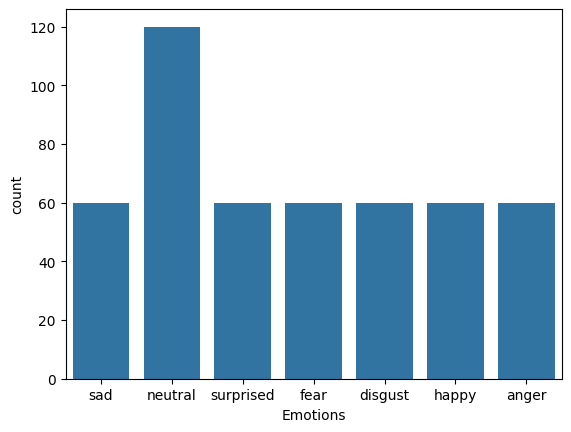

In [53]:
import seaborn as sns
sns.countplot(x='Emotions', data=savee_df)

Double the amount of neutral to make balanced only half of the neutral sounds will be used

In [54]:
len(savee_df)

480

In [136]:
for ang in range(len(savee_df)):
    if savee_df.loc[ang, 'Emotions']=='anger':
        print(ang)

52
56
71
89
99
100
112
113
128
129
133
139
142
143
155
161
170
171
183
196
199
217
218
222
242
243
248
249
273
278
280
286
287
291
305
307
317
319
321
322
332
333
342
343
352
353
354
355
364
365
373
383
384
385
393
399
407
408
416
417


In [138]:
savee_df.loc[52,'Path']

'KL_a09.wav'

In [134]:
print(savee_df.loc[10,'Emotions'])

sad


In [56]:
neutral_rows = savee_df[savee_df['Emotions'] == 'neutral']

neutrals = neutral_rows.sample(n=60)

savee_df = savee_df.drop(neutrals.index).reset_index(drop=True)

<Axes: xlabel='Emotions', ylabel='count'>

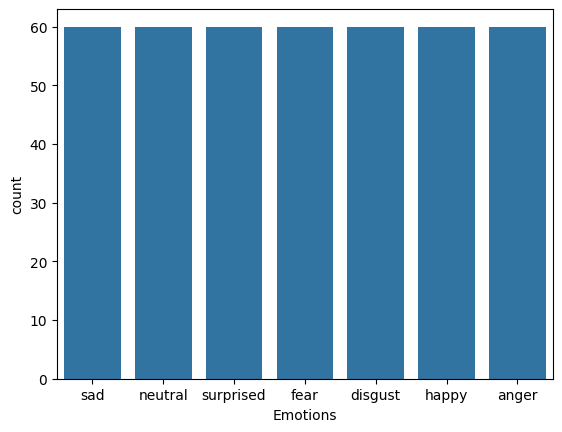

In [57]:
sns.countplot(x='Emotions', data=savee_df)

In [144]:
#Sad
sample_rate=None
data=None
def read_file(wav):
    global data
    global sample_rate
    file = os.path.join('ALL', wav)
    sample_rate, data = wavfile.read(file)
    
    
def play_file(sample_rate, data):
    sd.play(data, samplerate=sample_rate)

sad_wav=savee_df.loc[0, 'Path']
read_file(sad_wav)

In [ ]:
play_file(read_file('KL_a09.wav'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/audioflux/display/display.py:179: UserWarning: Display after performing abs on complex numbers
  warnings.warn('Display after performing abs on complex numbers')


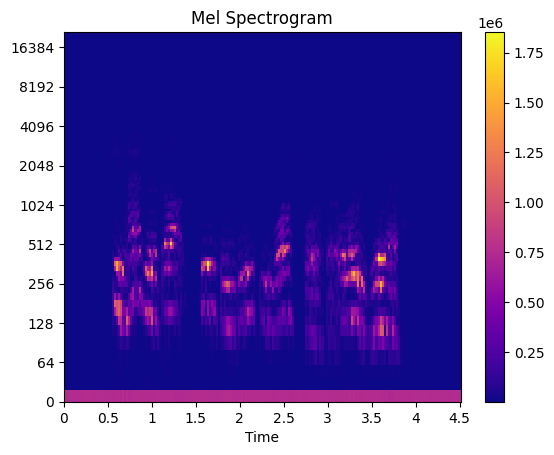

In [145]:
bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                scale_type=SpectralFilterBankScaleType.MEL)
spec_arr = bft_obj.bft(data)
fig,ax = plt.subplots()
img = fill_spec(spec_arr, axes=ax,
                x_coords=bft_obj.x_coords(data.shape[-1]),
                y_coords=bft_obj.y_coords(),
                x_axis='time', y_axis='log', title='Mel Spectrogram')
fig.colorbar(img)
plt.show()

In [60]:
print(spec_arr.dtype)

complex64


In [61]:
def graphs(sample_rate, data):
    # 3x2 grid
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    fig.tight_layout(pad=3.0)

    # General wave
    af.display.fill_wave(data, samplate=sample_rate, axes=axs[0, 0])

    # Mel Spectrogram
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                     scale_type=SpectralFilterBankScaleType.MEL)
    spec_arr = bft_obj.bft(data)
    img = fill_spec(spec_arr, axes=axs[0, 1],
                    x_coords=bft_obj.x_coords(data.shape[-1]),
                    y_coords=bft_obj.y_coords(),
                    x_axis='time', y_axis='log', title='Mel Spectrogram')
    fig.colorbar(img, ax=axs[0, 1])

    # MFCC
    bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                     scale_type=SpectralFilterBankScaleType.MEL,
                     data_type=SpectralDataType.POWER)
    spec_arr = bft_obj.bft(data)
    xxcc_obj = af.XXCC(bft_obj.num)
    xxcc_obj.set_time_length(time_length=spec_arr.shape[-1])
    mfcc_arr = xxcc_obj.xxcc(spec_arr)
    img = fill_spec(mfcc_arr, axes=axs[1, 0],
                    x_coords=bft_obj.x_coords(data.shape[-1]), x_axis='time', title='MFCC')
    fig.colorbar(img, ax=axs[1, 0])

    # CQT
    cqt_obj = af.CQT(num=84, samplate=sample_rate)
    cqt_arr = cqt_obj.cqt(data)
    img = fill_spec(cqt_arr, axes=axs[1, 1],
                    x_coords=cqt_obj.x_coords(data.shape[-1]),
                    y_coords=cqt_obj.y_coords(),
                    x_axis='time', y_axis='log', title='CQT')
    fig.colorbar(img, ax=axs[1, 1])

    # Chroma-CQT
    chroma_cqt_arr = cqt_obj.chroma(cqt_arr)
    img = fill_spec(chroma_cqt_arr, axes=axs[2, 0],
                    x_coords=cqt_obj.x_coords(data.shape[-1]),
                    x_axis='time', y_axis='chroma', title='Chroma-CQT')
    fig.colorbar(img, ax=axs[2, 0])

    # CWT
    cwt_obj = af.CWT(num=84, radix2_exp=12, samplate=sample_rate,
                     wavelet_type=WaveletContinueType.MORSE,
                     scale_type=SpectralFilterBankScaleType.OCTAVE)
    cwt_arr = np.abs(cwt_obj.cwt(data[..., :4096]))
    img = fill_spec(cwt_arr, axes=axs[2, 1],
                    x_coords=cwt_obj.x_coords(),
                    y_coords=cwt_obj.y_coords(),
                    x_axis='time', y_axis='log', title='CWT Spectrogram')
    fig.colorbar(img, ax=axs[2, 1])

    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/audioflux/display/display.py:267: RuntimeWarning: overflow encountered in scalar subtract
  y_blank_len = np.abs(y_max - y_min) * y_blank_threshold


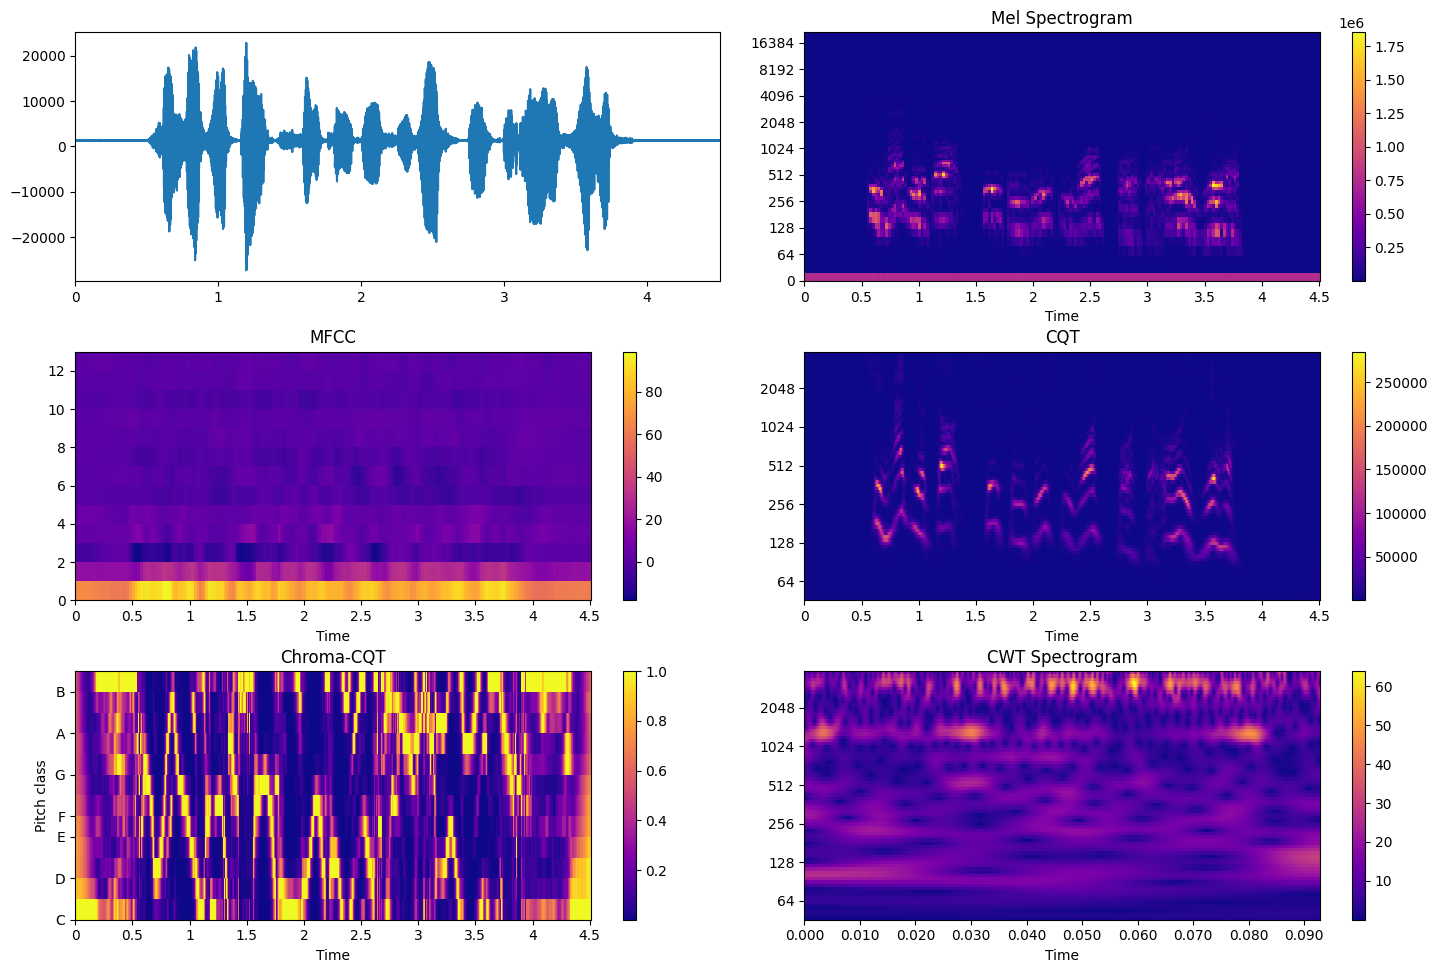

In [62]:
#Sad Emotion
graphs(sample_rate, data)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/audioflux/display/display.py:267: RuntimeWarning: overflow encountered in scalar subtract
  y_blank_len = np.abs(y_max - y_min) * y_blank_threshold
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/audioflux/display/display.py:179: UserWarning: Display after performing abs on complex numbers
  warnings.warn('Display after performing abs on complex numbers')


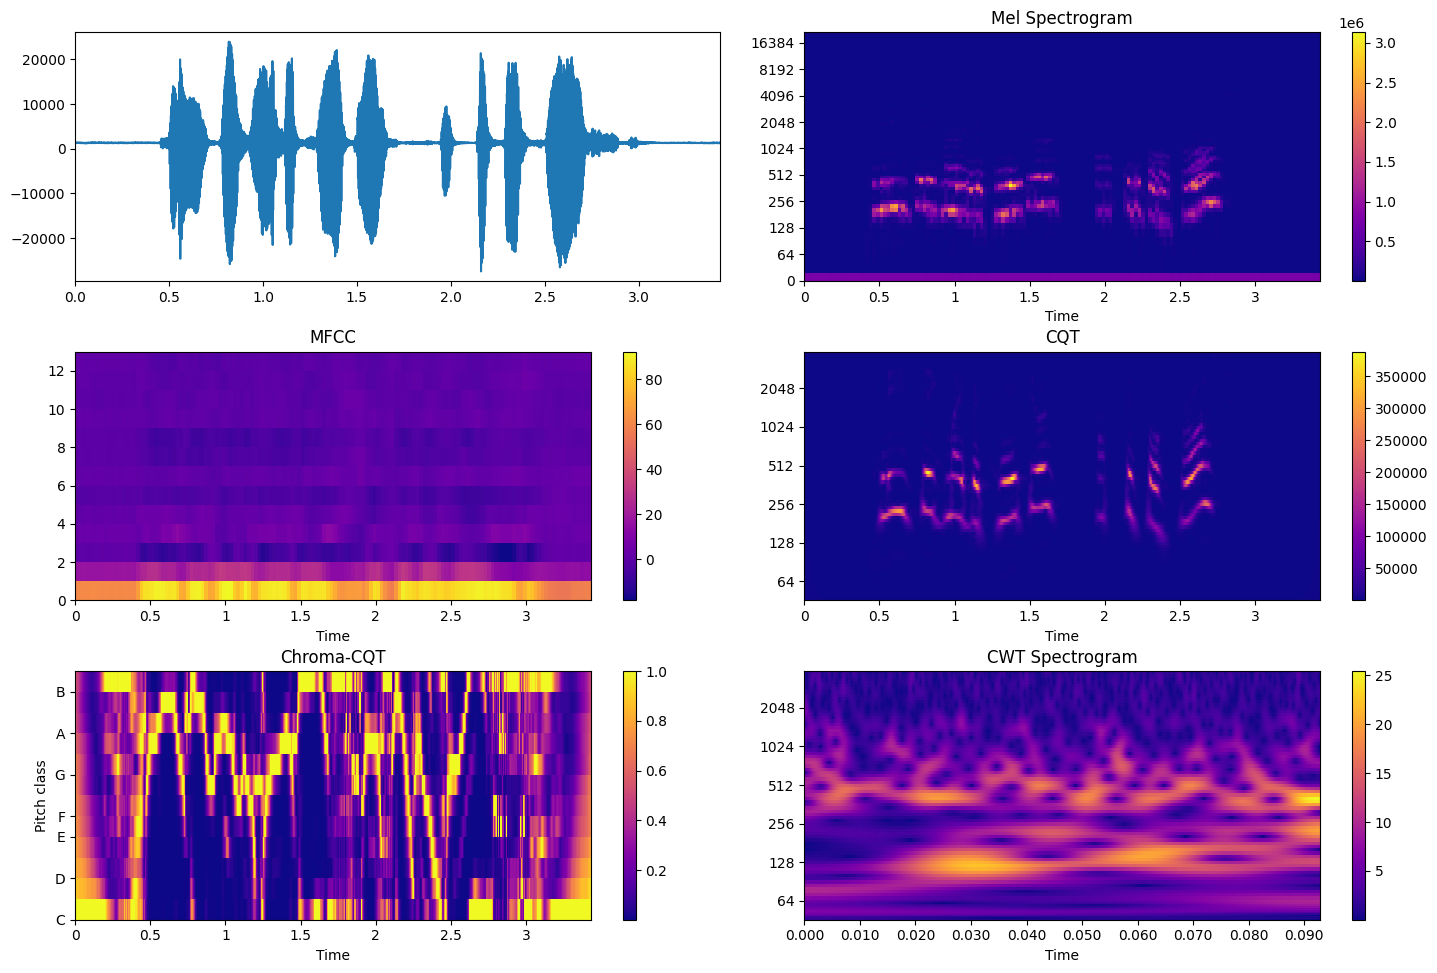

In [15]:
#Surprised Emotion
surprised_wav=savee_df.loc[3, 'Path']
read_file(surprised_wav)
graphs(sample_rate, data)

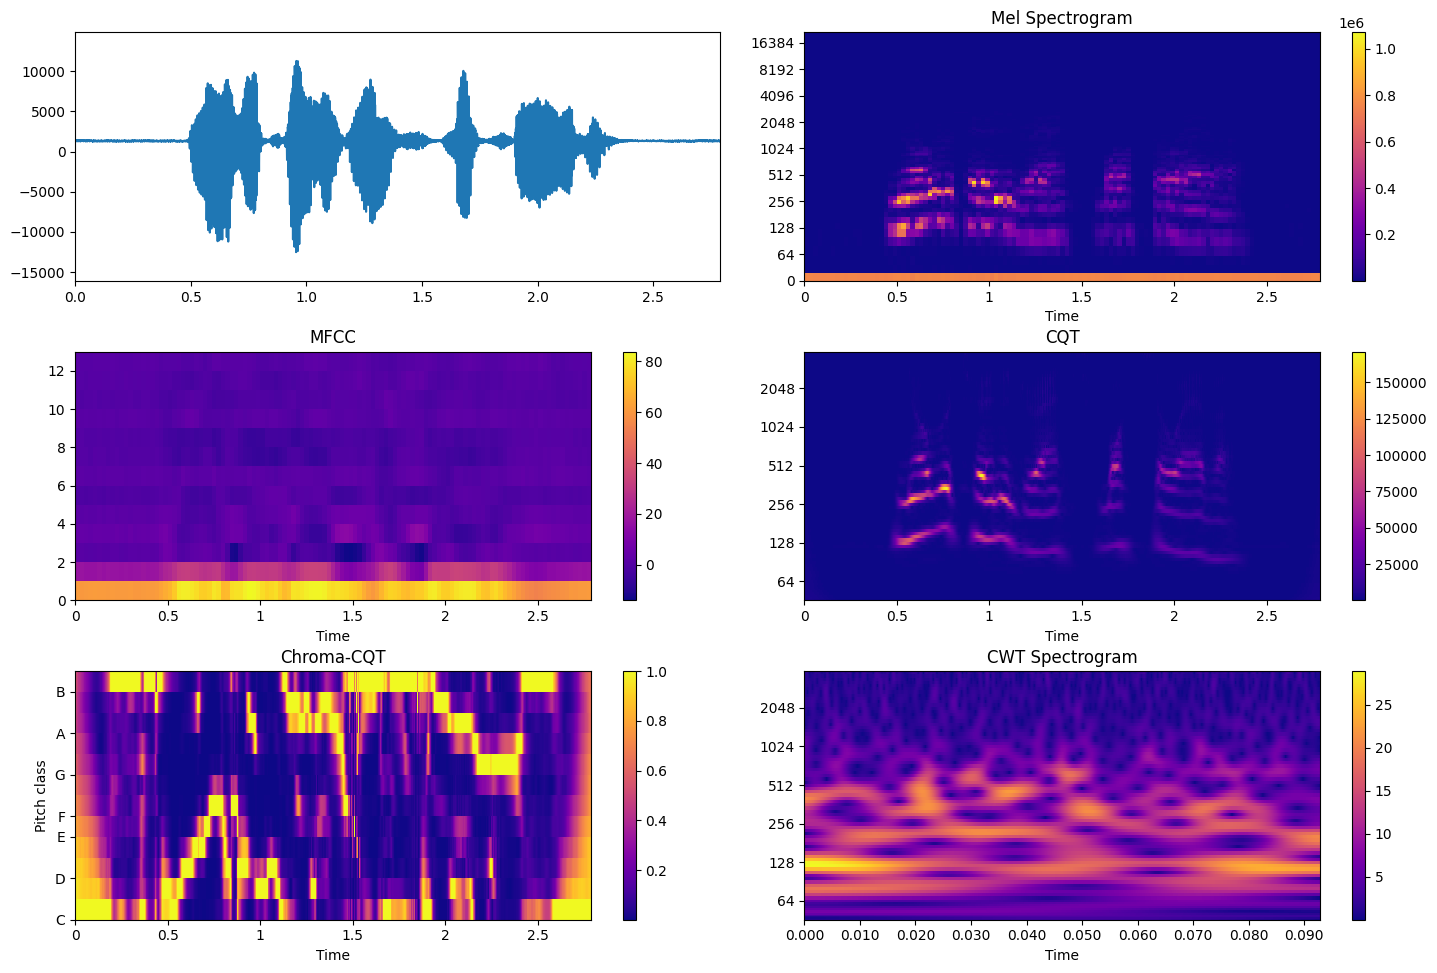

In [117]:
#Neutral Emotion
n_wav=savee_df.loc[2, 'Path']
read_file(n_wav)
graphs(sample_rate, data)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/audioflux/display/display.py:267: RuntimeWarning: overflow encountered in scalar subtract
  y_blank_len = np.abs(y_max - y_min) * y_blank_threshold
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/audioflux/display/display.py:179: UserWarning: Display after performing abs on complex numbers
  warnings.warn('Display after performing abs on complex numbers')


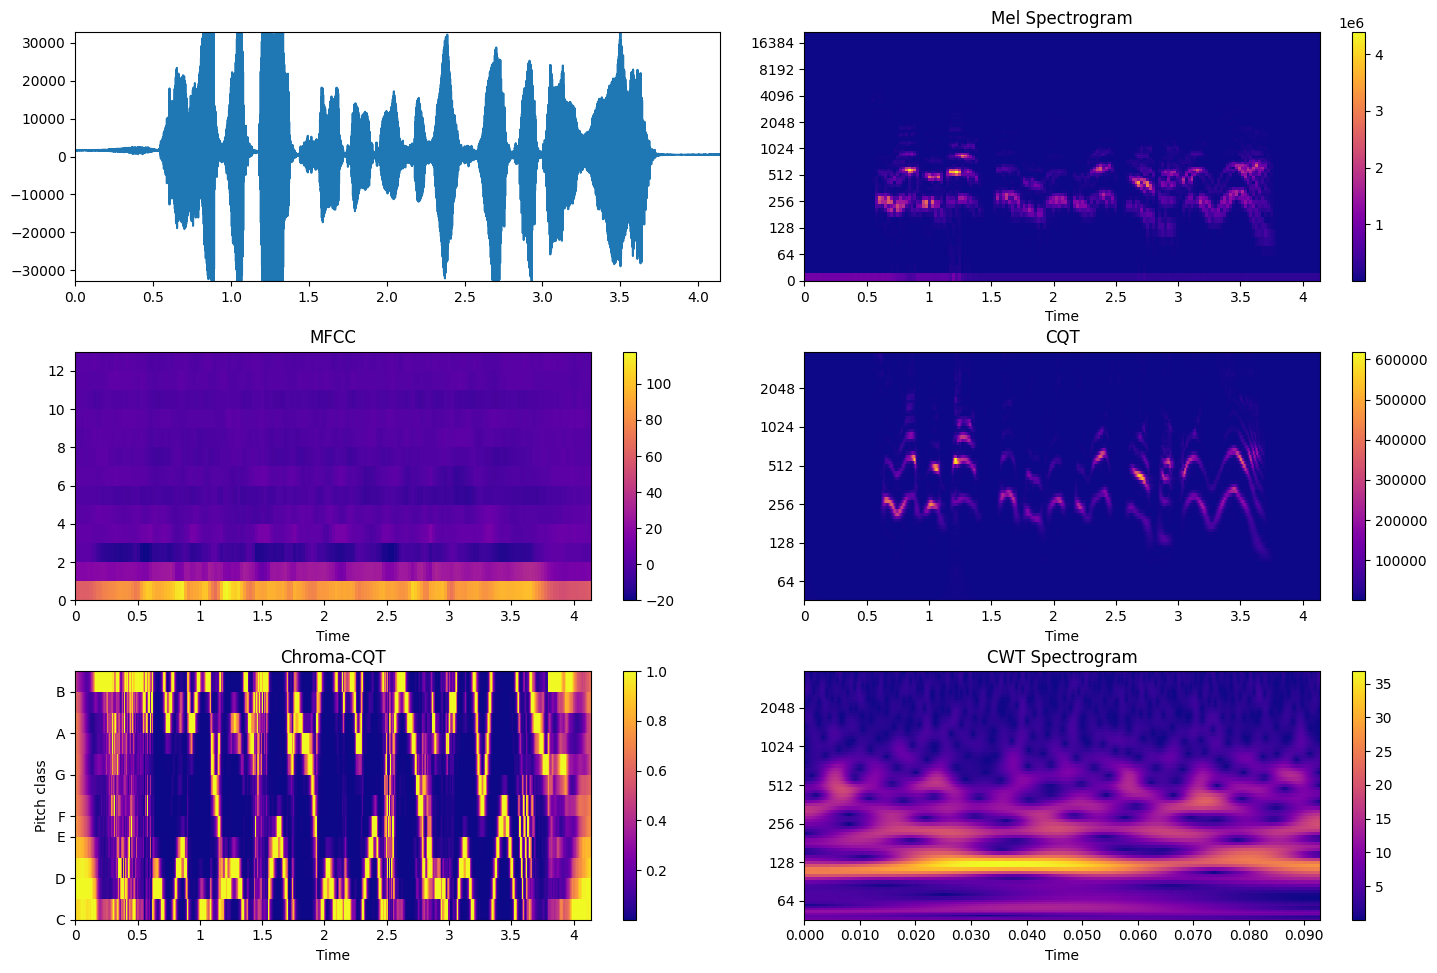

In [119]:
#Fear Emotion
fear_wav=savee_df.loc[9, 'Path']
read_file(fear_wav)
graphs(sample_rate, data)

In [63]:
cwts=[]
def turning_audio_to_CWT_Spectogram(savee_df):
    for wav in savee_df:
        file = os.path.join('ALL', wav)
        sample_rate, data = wavfile.read(file)
        cwt_obj = af.CWT(num=84, radix2_exp=12, samplate=sample_rate,
                     wavelet_type=WaveletContinueType.MORSE,
                     scale_type=SpectralFilterBankScaleType.OCTAVE)
        cwt_arr = np.abs(cwt_obj.cwt(data[..., :4096]))
        cwts.append(cwt_arr)

In [154]:
savee_df.loc[0]

Emotions            sad
Path        JK_sa01.wav
Name: 0, dtype: object

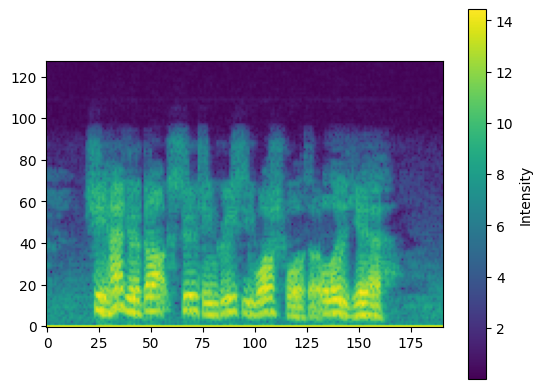

In [231]:
file = os.path.join('ALL', 'JK_sa01.wav')
sample_rate, data = wavfile.read(file)

bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                scale_type=SpectralFilterBankScaleType.MEL)
spec_arr = bft_obj.bft(data)
spec_arr = np.abs(spec_arr)
fig,ax = plt.subplots()
processed_array = np.log1p(spec_arr)
'''img = fill_spec(spec_arr, axes=ax,
                x_coords=bft_obj.x_coords(data.shape[-1]),
                y_coords=bft_obj.y_coords(),
                x_axis='time', y_axis='log', title='Mel Spectrogram')'''
plt.imshow(processed_array, origin='lower')
plt.colorbar(label='Intensity')

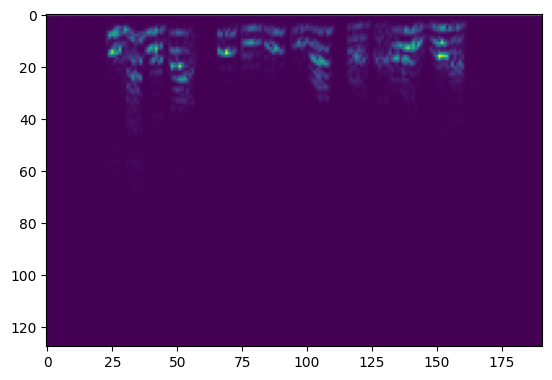

In [234]:
plt.imshow(spec_arr)

In [224]:
data.shape[-1]/sample_rate

4.511836734693878

In [186]:
import cv2

mel_spec=[]
def turning_mel(savee_df):
    try:
        for wav in savee_df:
            file = os.path.join(f'ALL/{wav}')
            sample_rate, data = wavfile.read(file)
            bft_obj = af.BFT(num=128, radix2_exp=12, samplate=sample_rate,
                         scale_type=SpectralFilterBankScaleType.MEL)
            spec_arr = bft_obj.bft(data)
            spec_arr = np.abs(spec_arr)
            spec_arr = np.log1p(spec_arr)
            image = cv2.resize(spec_arr, (200,120), interpolation=cv2.INTER_AREA)
            mel_spec.append(image)
    except Exception as e:
            print(f"Error processing file {wav}: {e}")

turning_mel(savee_df.loc[:, 'Path'])

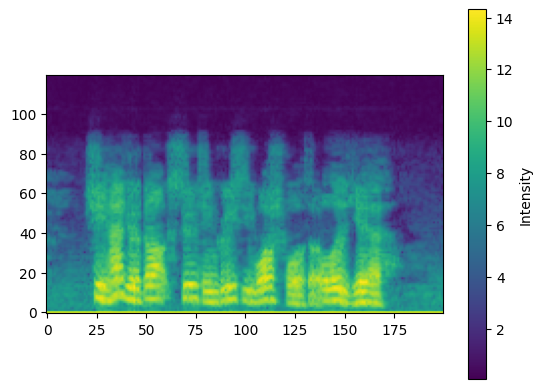

In [187]:
plt.imshow(mel_spec[0], origin='lower')
plt.colorbar(label='Intensity')

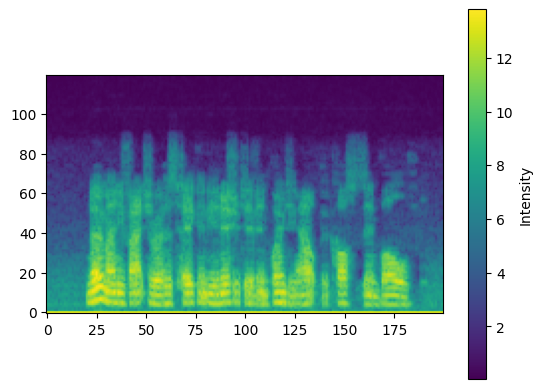

In [188]:
plt.imshow(mel_spec[1], origin='lower')
plt.colorbar(label='Intensity')

In [189]:
y= savee_df.loc[:, 'Emotions']

In [190]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['sad', 'fear', 'anger', 'disgust', 'neutral', 'surprised', 'happy'])
y_transformed=le.transform(y)

NOTE : It has marked:

0 - Anger 

1 - Disgust

2 - Fear

3 - Happy

4 - Neutral

5 - Sad

6 - Surprised

In [191]:
#list(le.inverse_transform(y))

In [192]:
mel_spec[0].shape #ALL DIFFERENT SIZES NEED TO BE THE SAME

(120, 200)

In [193]:
mel_spec[1].shape

(120, 200)

In [194]:
X = np.array(mel_spec)

In [195]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.4, random_state=42)

In [196]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [197]:
X_train.shape

(252, 120, 200)

In [198]:
X_test.shape

(84, 120, 200)

In [199]:
X_reshaped = X_train.reshape(252, 120*200)
X_val_reshaped = X_val.reshape(84, 120*200)
X_test_reshaped = X_test.reshape(84, 120*200)

In [200]:
X_train.shape

(252, 120, 200)

In [201]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

k_list = []
scores_list = [] 
 
for k in range(1,26):
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="euclidean")
        knn.fit(X_reshaped,y_train)
        y_pred=knn.predict(np.array(X_test_reshaped)) 
        k_list.append(k)
        accuracy = metrics.accuracy_score(y_test,y_pred)
        print(k, 'accuracy',accuracy)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))

1 accuracy 0.42857142857142855
2 accuracy 0.42857142857142855
3 accuracy 0.42857142857142855
4 accuracy 0.40476190476190477
5 accuracy 0.42857142857142855
6 accuracy 0.4166666666666667
7 accuracy 0.40476190476190477
8 accuracy 0.40476190476190477
9 accuracy 0.34523809523809523
10 accuracy 0.38095238095238093
11 accuracy 0.35714285714285715
12 accuracy 0.3333333333333333
13 accuracy 0.36904761904761907
14 accuracy 0.40476190476190477
15 accuracy 0.34523809523809523
16 accuracy 0.36904761904761907
17 accuracy 0.34523809523809523
18 accuracy 0.38095238095238093
19 accuracy 0.34523809523809523
20 accuracy 0.34523809523809523
21 accuracy 0.34523809523809523
22 accuracy 0.34523809523809523
23 accuracy 0.32142857142857145
24 accuracy 0.2976190476190476
25 accuracy 0.32142857142857145


In [202]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
dtc.fit(X_reshaped, y_train)
y_pred = dtc.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.2976190476190476


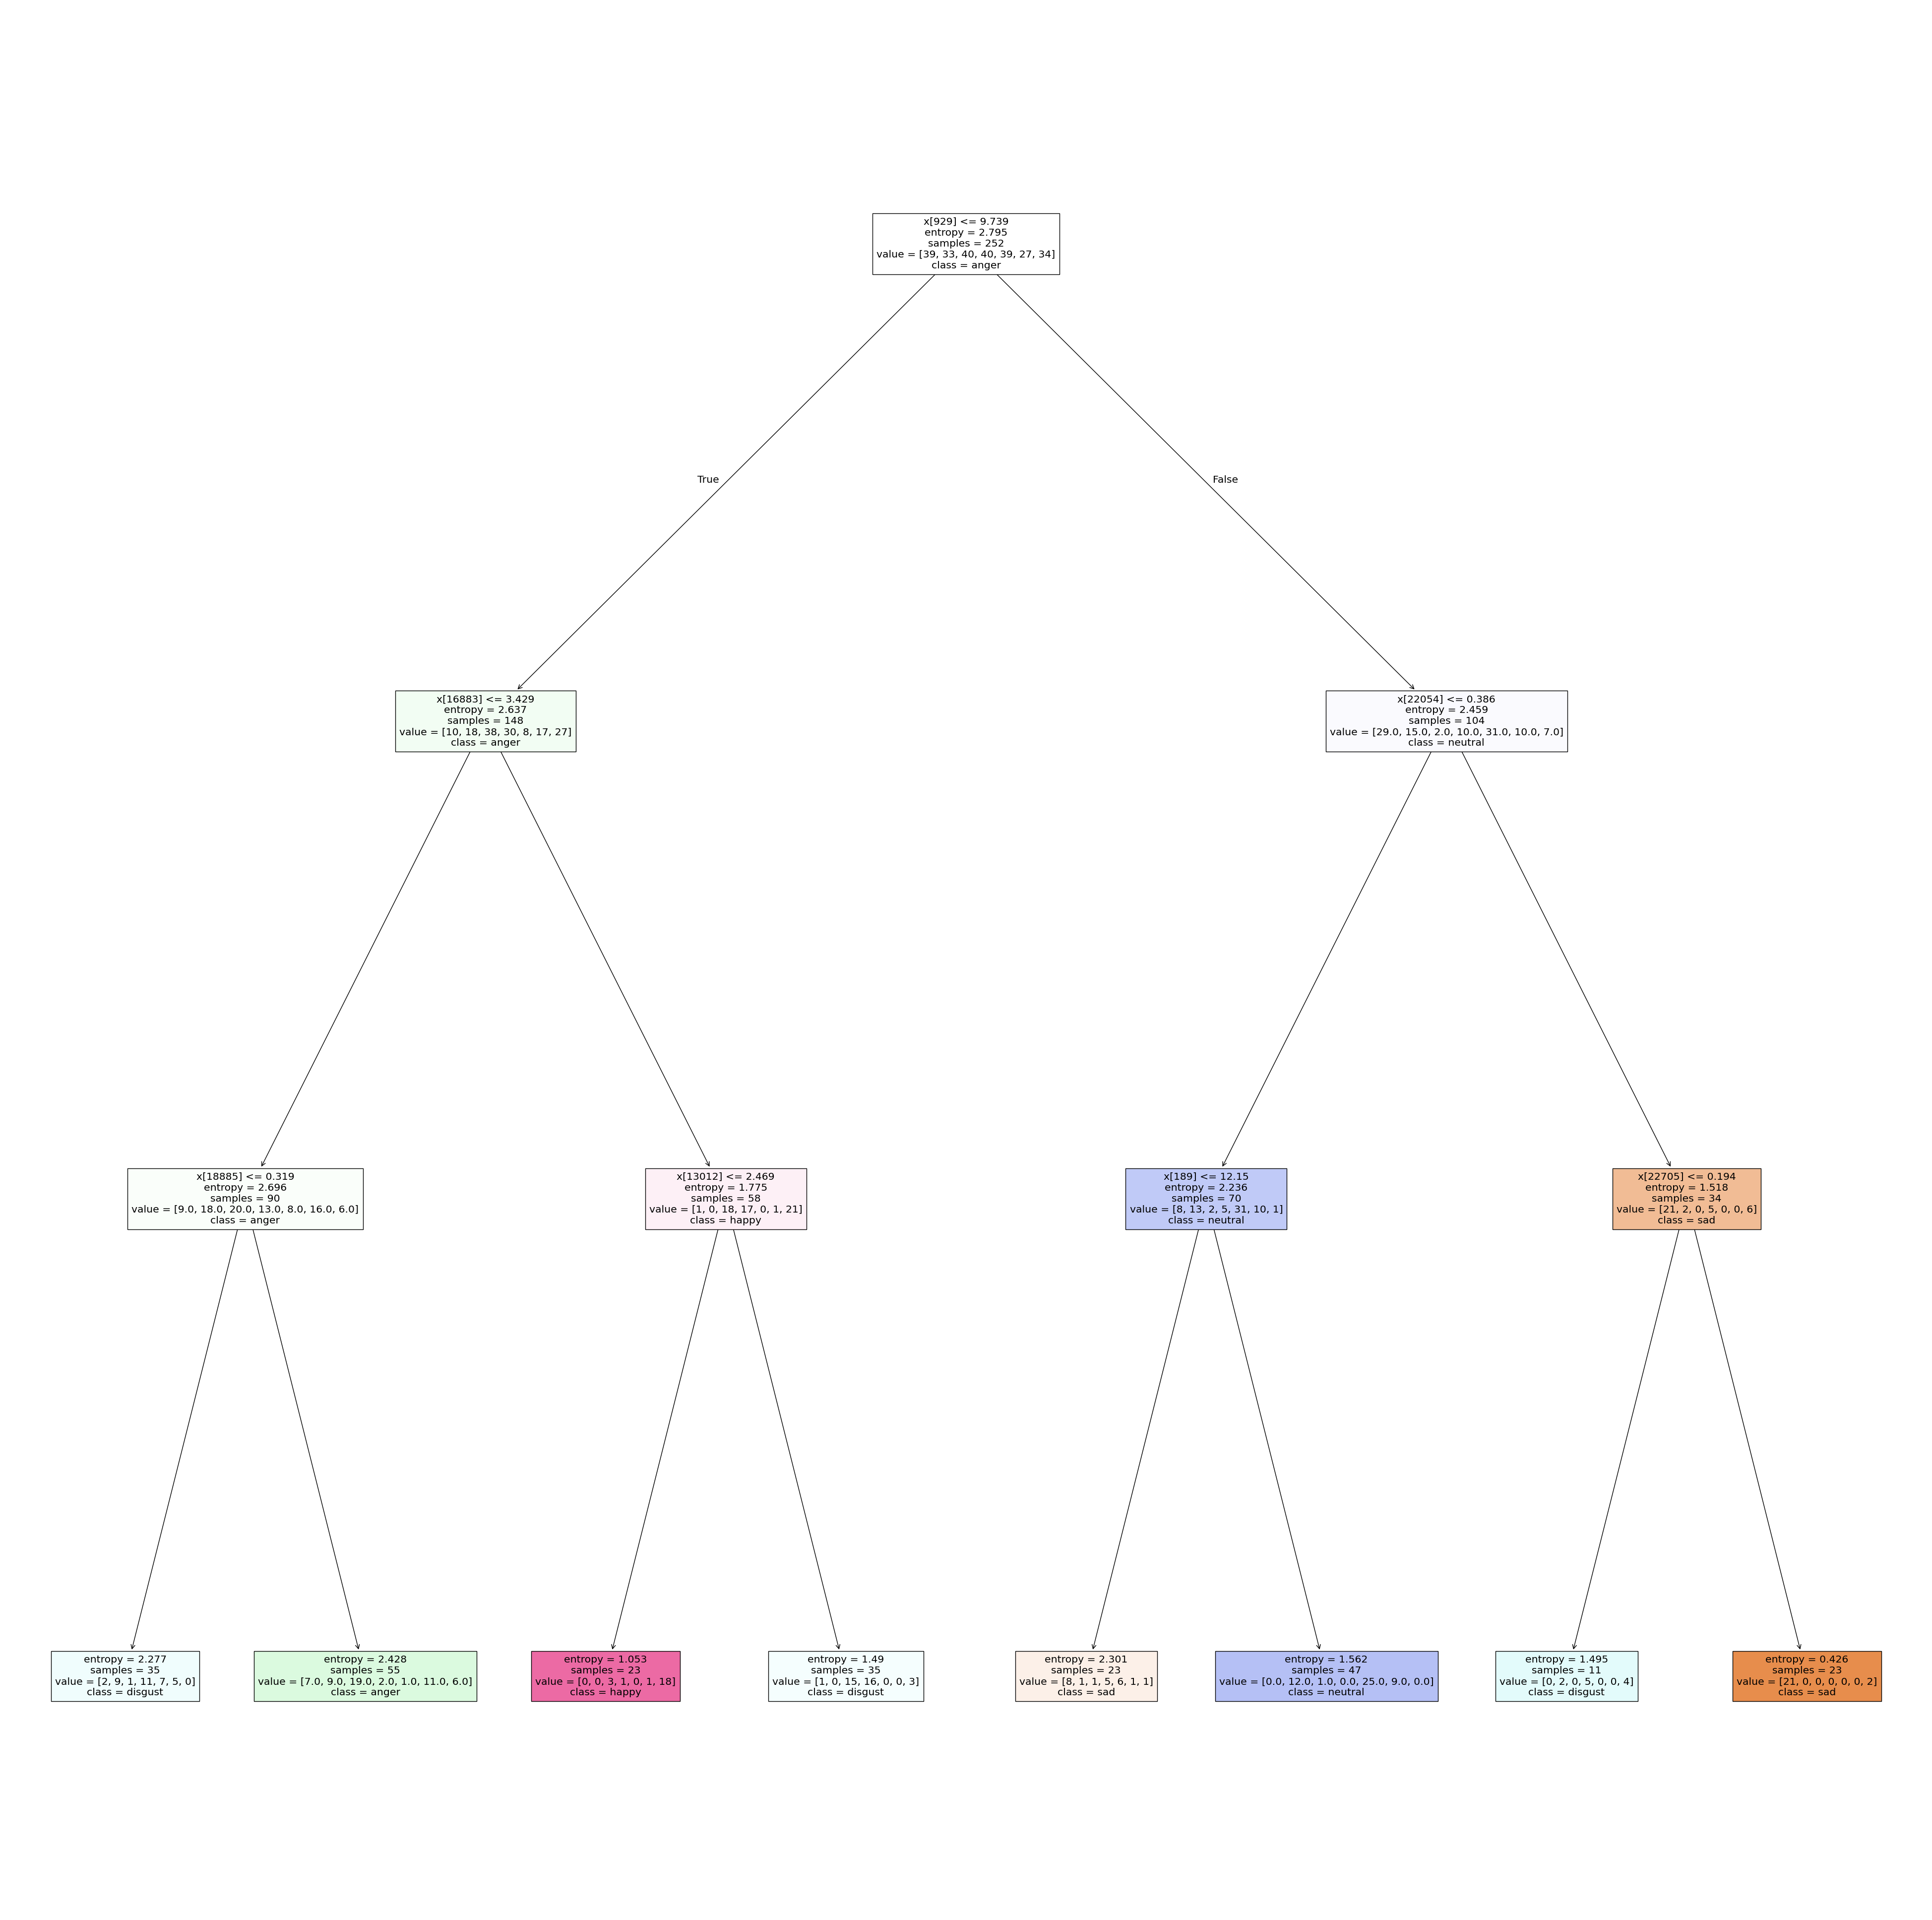

In [203]:
plt.figure(figsize=(50,50))
_ = tree.plot_tree(dtc, class_names=['sad', 'fear', 'anger', 'disgust', 'neutral', 'surprised', 'happy'], filled=True)

In [204]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_reshaped, y_train)
y_pred = rfc.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))

0.4166666666666667


In [205]:
"""from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_reshaped, y_train)
y_pred = xgb.predict(X_test_reshaped)
print(accuracy_score(y_test, y_pred))"""

'from xgboost import XGBClassifier\n\nxgb = XGBClassifier()\nxgb.fit(X_reshaped, y_train)\ny_pred = xgb.predict(X_test_reshaped)\nprint(accuracy_score(y_test, y_pred))'

In [206]:
X_train[0].shape

(120, 200)

In [207]:
import tensorflow

In [208]:
# model from https://medium.com/@sanjay_dutta/designing-your-own-convolutional-neural-network-cnn-model-a-step-by-step-guide-for-beginners-4e8b57836c81
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 200, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [209]:
history = model.fit(X_train,y_train,
                    epochs=10,
                    validation_data=(X_val,y_val))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 363ms/step - accuracy: 0.1686 - loss: 9.7841 - val_accuracy: 0.0833 - val_loss: 2.1401
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.1673 - loss: 2.1447 - val_accuracy: 0.1667 - val_loss: 2.0859
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.1856 - loss: 2.0316 - val_accuracy: 0.2381 - val_loss: 1.9775
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.2566 - loss: 1.8758 - val_accuracy: 0.1786 - val_loss: 1.9724
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.3269 - loss: 1.7226 - val_accuracy: 0.2143 - val_loss: 1.8662
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - accuracy: 0.3949 - loss: 1.5343 - val_accuracy: 0.2619 - val_loss: 1.8766
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.5652 - loss: 1.2813 - val_accuracy: 0.2143 - val_loss: 2.0934
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.6599 - loss: 0.9196 - val_accuracy: 0.2143 - val_loss:

In [210]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2362 - loss: 2.5924


[2.67641282081604, 0.2380952388048172]

https://www.sciencedirect.com/science/article/pii/S0003682X18300409
Try following the work of what they have done here